# Conditional Neural Processes (CNP).
[Conditional Neural Processes](https://arxiv.org/pdf/1807.01613.pdf) (CNPs) were
introduced as a continuation of
[Generative Query Networks](https://deepmind.com/blog/neural-scene-representation-and-rendering/)
(GQN) to extend its training regime to tasks beyond scene rendering, e.g. to
regression and classification.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import datetime
import numpy as np
import os
from resum.utilities import plotting_utils_cnp as plotting
from resum.utilities import utilities as utils
from resum.conditional_neural_process import DataGeneration
from resum.conditional_neural_process import DeterministicModel
from torch.utils.tensorboard import SummaryWriter
import csv
import yaml
import shap

In [ ]:
with open("../binary-black-hole/settings.yaml", "r") as f:
    config_file = yaml.safe_load(f)

PLOT_AFTER = int(config_file["cnp_settings"]["plot_after"])
torch.manual_seed(0)
FILES_PER_BATCH = config_file["cnp_settings"]["files_per_batch_test"]
target_range = config_file["simulation_settings"]["target_range"]
is_binary = target_range[0] >= 0 and target_range[1] <= 1

path_out = config_file["path_settings"]["path_out"]
f_out = config_file["path_settings"]["f_out"]



In [8]:
x_size, y_size = utils.get_feature_and_label_size(config_file)
theta_size=len(config_file["simulation_settings"]["theta_headers"])

In [5]:
d_x, d_in, representation_size, d_out = x_size , x_size+y_size, 32, y_size+1
encoder_sizes = [d_in, 32, 64, 128, 128, 128, 64, 48, representation_size]
decoder_sizes = [representation_size + d_x, 32, 64, 128, 128, 128, 64, 48, d_out]

model = DeterministicModel(encoder_sizes,decoder_sizes)
model.load_state_dict(torch.load(f'{path_out}/{f_out}_model.pth'))
model.eval()

DeterministicModel(
  (_encoder): DeterministicEncoder(
    (linears): ModuleList(
      (0): Linear(in_features=31, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3-4): 2 x Linear(in_features=128, out_features=128, bias=True)
      (5): Linear(in_features=128, out_features=64, bias=True)
      (6): Linear(in_features=64, out_features=48, bias=True)
      (7): Linear(in_features=48, out_features=32, bias=True)
    )
  )
  (_decoder): DeterministicDecoder(
    (linears): ModuleList(
      (0): Linear(in_features=62, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3-4): 2 x Linear(in_features=128, out_features=128, bias=True)
      (5): Linear(in_features=128, out_features=64, bias=True)
      (6): Linear(in_features=64, out_features=48, bias=True)
      (7): Linear(

In [6]:
bce = nn.BCELoss()
iter_testing = 0

# create a PdfPages object
test_idx=0
it_batch = 0

with open(f'{path_out}/output.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    headers = ['# n_samples'] + [*config_file["simulation_settings"]["theta_headers"]] + ['y_cnp', 'y_cnp_err', 'y_raw', 'log_prop','bce']
    writer.writerow(headers)

path=config_file["path_settings"]["path_to_test_files"][0]
    
USE_DATA_AUGMENTATION = False
# load data:

dataset_predict = DataGeneration(mode = "predict", config_file=config_file, 
                                path_to_files=path, 
                                use_data_augmentation=USE_DATA_AUGMENTATION, 
                                batch_size=config_file["cnp_settings"]["batch_size_test"][0], 
                                files_per_batch=FILES_PER_BATCH)
dataset_predict.set_loader()
dataloader_predict = dataset_predict.dataloader

Shape of batch_target_x: torch.Size([1, 1000, 30])


  0%|          | 0/10 [00:00<?, ?it/s]

/var/folders/99/0svbmlns6xs9l9p55lcr912r0000gn/T/ipykernel_52230/1046182482.py:84: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, target_x_explain_flat)
/Users/aschuetz/.local/modules/miniconda/miniconda3/envs/legend/lib/python3.10/site-packages/shap/plots/_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/Users/aschuetz/.local/modules/miniconda/miniconda3/envs/legend/lib/python3.10/site-packages/shap/plots/_beeswarm.py:736: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  pl.xlim((slow, shigh))
/Users/asc

<Figure size 640x480 with 0 Axes>

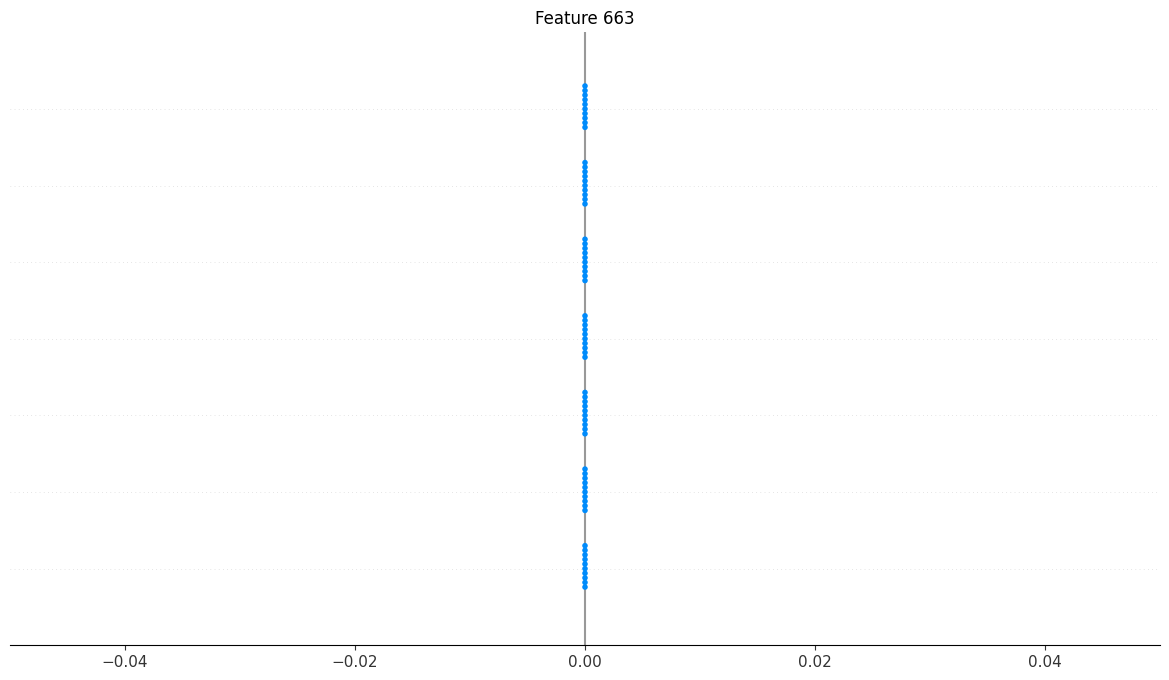

In [7]:




# ===== Step 0: Ensure Your Model is in Evaluation Mode =====
model.eval()

# ===== Step 1: Prepare Background and Explanation Data =====
# Get one batch from your test DataLoader
batch = next(iter(dataloader_predict))
batch_formatted = dataset_predict.format_batch_for_cnp(batch, config_file["cnp_settings"]["context_is_subset"])

# Unpack the query tuple:
# Your query is structured as: query = ((batch_context_x, batch_context_y), batch_target_x)
(batch_context_x, batch_context_y), batch_target_x = batch_formatted.query

print("Shape of batch_target_x:", batch_target_x.shape)  # Expect torch.Size([1, 500, 30])

# Since we have only one sample, we replicate it to create a background set.
num_repeats = 10  # Number of background samples

# Convert tensors to numpy arrays
context_x_np = batch_context_x.detach().numpy()
context_y_np = batch_context_y.detach().numpy()
target_x_np  = batch_target_x.detach().numpy()

# Replicate along the batch dimension
context_x_background = np.repeat(context_x_np, num_repeats, axis=0)
context_y_background = np.repeat(context_y_np, num_repeats, axis=0)
target_x_background  = np.repeat(target_x_np, num_repeats, axis=0)

# For explanation data, you can also replicate the same sample or add slight perturbations.
# Here, we simply replicate the same sample.
context_x_explain = context_x_background.copy()
context_y_explain = context_y_background.copy()
target_x_explain  = target_x_background.copy()

# -------------------------------------------------------------------
# IMPORTANT: SHAP's KernelExplainer expects each instance to be a 1D or 2D array.
# Your target_x has shape (num_samples, num_target_points, target_feature_dim).
# We flatten the last two dimensions so that each instance becomes 1D.
num_target_points = target_x_background.shape[1]
target_feature_dim = target_x_background.shape[2]

target_x_background_flat = target_x_background.reshape(target_x_background.shape[0], -1)
target_x_explain_flat    = target_x_explain.reshape(target_x_explain.shape[0], -1)

# ===== Step 2: Define a Prediction Function for SHAP =====
def predict_fn(flat_target_x_np):
    """
    flat_target_x_np: NumPy array of shape (batch_size, num_target_points * target_feature_dim)
    """
    batch_size = flat_target_x_np.shape[0]
    # Reshape back to original target dimensions: (batch_size, num_target_points, target_feature_dim)
    target_x_tensor = torch.tensor(flat_target_x_np, dtype=torch.float32)
    target_x_tensor = target_x_tensor.reshape(batch_size, num_target_points, target_feature_dim)
    
    # For context, we use a fixed baseline.
    # Here, we take the first sample from the background context and repeat it for each input in the batch.
    dummy_context_x_single = torch.tensor(context_x_background[0:1], dtype=torch.float32)
    dummy_context_y_single = torch.tensor(context_y_background[0:1], dtype=torch.float32)
    dummy_context_x_batch = dummy_context_x_single.repeat(batch_size, 1, 1)
    dummy_context_y_batch = dummy_context_y_single.repeat(batch_size, 1, 1)
    
    # Reconstruct the query as expected by your model:
    # query = ((context_x, context_y), target_x)
    query = ((dummy_context_x_batch, dummy_context_y_batch), target_x_tensor)
    
    # Create a dummy target_y with the same shape as target_x_tensor.
    dummy_target_y = torch.zeros_like(target_x_tensor)
    
    with torch.no_grad():
        # Your model returns (log_prob, mu, uncertainty); we focus on mu.
        _, mu, _ = model(query, dummy_target_y, is_binary)
    
    # Flatten the output so that each instance is 1D for SHAP.
    mu_np = mu.detach().numpy().reshape(batch_size, -1)
    return mu_np

# ===== Step 3: Use SHAP's KernelExplainer =====
explainer = shap.KernelExplainer(predict_fn, target_x_background_flat)

# Compute SHAP values for the explanation data.
# Note: KernelExplainer can be slow. Here we use the replicated explanation data.
shap_values = explainer.shap_values(target_x_explain_flat)

# ===== Step 4: Visualize the SHAP Values =====
shap.summary_plot(shap_values, target_x_explain_flat)
